In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import shap


from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
import xgboost as xgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, auc, precision_recall_curve, confusion_matrix,
                           classification_report, average_precision_score)
from sklearn.calibration import calibration_curve


c:\Users\okpl8\anaconda3\envs\LG\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.font_manager as fm
# 1. 설치된 한글 폰트 확인
fonts = [f.name for f in fm.fontManager.ttflist]
print('설치된 폰트 목록:', fonts)

# 2. 한글 폰트 설정 (아래 폰트 중 하나 선택)
plt.rc('font', family='Malgun Gothic')  # 맑은 고딕
# plt.rc('font', family='NanumGothic')  # 나눔고딕
# plt.rc('font', family='NanumBarunGothic')  # 나눔바른고딕

# 3. 마이너스 기호 깨짐 방지
plt.rc('axes', unicode_minus=False)

설치된 폰트 목록: ['STIXSizeOneSym', 'DejaVu Sans Mono', 'STIXNonUnicode', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'cmr10', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Sans Mono', 'STIXSizeThreeSym', 'STIXSizeThreeSym', 'STIXSizeOneSym', 'STIXSizeFourSym', 'DejaVu Sans Mono', 'STIXSizeFourSym', 'STIXSizeTwoSym', 'STIXGeneral', 'cmmi10', 'DejaVu Serif', 'cmss10', 'cmtt10', 'cmb10', 'STIXGeneral', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'STIXGeneral', 'STIXGeneral', 'DejaVu Serif', 'DejaVu Sans', 'cmex10', 'cmsy10', 'STIXNonUnicode', 'STIXNonUnicode', 'STIXSizeTwoSym', 'STIXSizeFiveSym', 'STIXNonUnicode', 'DejaVu Serif Display', 'Franklin Gothic Heavy', 'Magic R', 'HYMyeongJo-Extra', 'French Script MT', 'Tw Cen MT Condensed', 'Javanese Text', 'Bodoni MT', 'Arial', 'Segoe UI', 'Segoe UI', 'Bodoni MT', 'HYSinMyeongJo-Medium', 'Comic Sans MS', 'Book Antiqua', 'Segoe MDL2 Assets', 'Leelawadee', 'Webdings', 'Wingdings', 'Poor Richard', 'Bodoni MT', 'Franklin Gothic Book', 'Eras Demi ITC', 'Leela

In [3]:
data = pd.read_csv('./data/train.csv')
data.head()

,ID,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,...,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,임신 성공 여부
0,TRAIN_000000,TRZKPL,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0
1,TRAIN_000001,TRYBLT,만45-50세,NaN,IVF,ICSI,0,알 수 없음,0.0,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
2,TRAIN_000002,TRVNRY,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,0.0,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,2.0,NaN,0
3,TRAIN_000003,TRJXFG,만35-37세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
4,TRAIN_000004,TRVNRY,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256351 non-null  object 
 1   시술 시기 코드               256351 non-null  object 
 2   시술 당시 나이               256351 non-null  object 
 3   임신 시도 또는 마지막 임신 경과 연수  9370 non-null    float64
 4   시술 유형                  256351 non-null  object 
 5   특정 시술 유형               256349 non-null  object 
 6   배란 자극 여부               256351 non-null  int64  
 7   배란 유도 유형               256351 non-null  object 
 8   단일 배아 이식 여부            250060 non-null  float64
 9   착상 전 유전 검사 사용 여부       2718 non-null    float64
 10  착상 전 유전 진단 사용 여부       250060 non-null  float64
 11  남성 주 불임 원인             256351 non-null  int64  
 12  남성 부 불임 원인             256351 non-null  int64  
 13  여성 주 불임 원인             256351 non-null  int64  
 14  여성 부 불임 원인             256351 non-nu

In [5]:
data.shape

(256351, 69)

In [6]:
data = data.drop(['ID'], axis = 1)

In [7]:
# object 타입의 컬럼들만 선택하여 unique 값 확인
categorical_columns = data.select_dtypes(include=['object']).columns

for col in categorical_columns:
    print(f"\n{col} 컬럼의 고유값:")
    print(data[col].value_counts())
    print("="*50)



시술 시기 코드 컬럼의 고유값:
시술 시기 코드
TRDQAZ    38969
TRCMWS    38090
TRYBLT    36713
TRVNRY    36173
TRJXFG    36031
TRZKPL    35544
TRXQMD    34831
Name: count, dtype: int64

시술 당시 나이 컬럼의 고유값:
시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64

시술 유형 컬럼의 고유값:
시술 유형
IVF    250060
DI       6291
Name: count, dtype: int64

특정 시술 유형 컬럼의 고유값:
특정 시술 유형
ICSI                                   122368
IVF                                     91755
Unknown                                 26939
IUI                                      6100
ICSI:ICSI                                2314
ICSI / BLASTOCYST                        1609
IVF / BLASTOCYST                         1248
IVF:IVF                                  1146
ICSI:IVF                                  873
ICSI / AH                                 769
IVF:ICSI                                  392
IVF / AH                                  31

In [8]:
# 추가로 int64나 float64 타입이지만 실제로는 범주형일 수 있는 컬럼들 중 
# unique 값이 적은 것들도 확인
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_columns:
    if data[col].nunique() < 10:  # 고유값이 10개 미만인 경우
        print(f"\n{col} 컬럼의 고유값:")
        print(data[col].value_counts())
        print("="*50)


배란 자극 여부 컬럼의 고유값:
배란 자극 여부
1    197720
0     58631
Name: count, dtype: int64

단일 배아 이식 여부 컬럼의 고유값:
단일 배아 이식 여부
0.0    191677
1.0     58383
Name: count, dtype: int64

착상 전 유전 검사 사용 여부 컬럼의 고유값:
착상 전 유전 검사 사용 여부
1.0    2718
Name: count, dtype: int64

착상 전 유전 진단 사용 여부 컬럼의 고유값:
착상 전 유전 진단 사용 여부
0.0    246864
1.0      3196
Name: count, dtype: int64

남성 주 불임 원인 컬럼의 고유값:
남성 주 불임 원인
0    249041
1      7310
Name: count, dtype: int64

남성 부 불임 원인 컬럼의 고유값:
남성 부 불임 원인
0    252989
1      3362
Name: count, dtype: int64

여성 주 불임 원인 컬럼의 고유값:
여성 주 불임 원인
0    248475
1      7876
Name: count, dtype: int64

여성 부 불임 원인 컬럼의 고유값:
여성 부 불임 원인
0    253164
1      3187
Name: count, dtype: int64

부부 주 불임 원인 컬럼의 고유값:
부부 주 불임 원인
0    247874
1      8477
Name: count, dtype: int64

부부 부 불임 원인 컬럼의 고유값:
부부 부 불임 원인
0    254104
1      2247
Name: count, dtype: int64

불명확 불임 원인 컬럼의 고유값:
불명확 불임 원인
0    192076
1     64275
Name: count, dtype: int64

불임 원인 - 난관 질환 컬럼의 고유값:
불임 원인 - 난관 질환
0    220794
1     35557
Name: count, dtype: 

In [9]:
# 결측치 확인
missing_values = data.isnull().sum()
print("결측치 현황:")
print(missing_values[missing_values > 0])

결측치 현황:
임신 시도 또는 마지막 임신 경과 연수    246981
특정 시술 유형                      2
단일 배아 이식 여부                6291
착상 전 유전 검사 사용 여부         253633
착상 전 유전 진단 사용 여부           6291
배아 생성 주요 이유                6291
총 생성 배아 수                  6291
미세주입된 난자 수                 6291
미세주입에서 생성된 배아 수            6291
이식된 배아 수                   6291
미세주입 배아 이식 수               6291
저장된 배아 수                   6291
미세주입 후 저장된 배아 수            6291
해동된 배아 수                   6291
해동 난자 수                    6291
수집된 신선 난자 수                6291
저장된 신선 난자 수                6291
혼합된 난자 수                   6291
파트너 정자와 혼합된 난자 수           6291
기증자 정자와 혼합된 난자 수           6291
동결 배아 사용 여부                6291
신선 배아 사용 여부                6291
기증 배아 사용 여부                6291
대리모 여부                     6291
PGD 시술 여부                254172
PGS 시술 여부                254422
난자 채취 경과일                 57488
난자 해동 경과일                254915
난자 혼합 경과일                 53735
배아 이식 경과일                 43566
배아 해동 경과일                215982


In [10]:
# 결측치 비율 계산
missing_ratio = (missing_values / len(data)) * 100
print("\n결측치 비율(%):")
print(missing_ratio[missing_ratio > 0])


결측치 비율(%):
임신 시도 또는 마지막 임신 경과 연수    96.344855
특정 시술 유형                  0.000780
단일 배아 이식 여부               2.454057
착상 전 유전 검사 사용 여부         98.939735
착상 전 유전 진단 사용 여부          2.454057
배아 생성 주요 이유               2.454057
총 생성 배아 수                 2.454057
미세주입된 난자 수                2.454057
미세주입에서 생성된 배아 수           2.454057
이식된 배아 수                  2.454057
미세주입 배아 이식 수              2.454057
저장된 배아 수                  2.454057
미세주입 후 저장된 배아 수           2.454057
해동된 배아 수                  2.454057
해동 난자 수                   2.454057
수집된 신선 난자 수               2.454057
저장된 신선 난자 수               2.454057
혼합된 난자 수                  2.454057
파트너 정자와 혼합된 난자 수          2.454057
기증자 정자와 혼합된 난자 수          2.454057
동결 배아 사용 여부               2.454057
신선 배아 사용 여부               2.454057
기증 배아 사용 여부               2.454057
대리모 여부                    2.454057
PGD 시술 여부                99.149994
PGS 시술 여부                99.247516
난자 채취 경과일                22.425503
난자 해동 경과일                99.439831
난자 혼합 경과

In [11]:
data = data.drop(['배란 유도 유형', '임신 시도 또는 마지막 임신 경과 연수'], axis = 1)
data

,시술 시기 코드,시술 당시 나이,시술 유형,특정 시술 유형,배란 자극 여부,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,남성 주 불임 원인,남성 부 불임 원인,...,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,임신 성공 여부
0,TRZKPL,만18-34세,IVF,ICSI,1,0.0,NaN,0.0,0,0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0
1,TRYBLT,만45-50세,IVF,ICSI,0,0.0,NaN,0.0,0,0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
2,TRVNRY,만18-34세,IVF,IVF,1,0.0,NaN,0.0,0,0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,2.0,NaN,0
3,TRJXFG,만35-37세,IVF,ICSI,1,0.0,NaN,0.0,0,0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
4,TRVNRY,만18-34세,IVF,ICSI,1,0.0,NaN,0.0,0,0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256346,TRYBLT,만18-34세,IVF,ICSI,1,0.0,NaN,0.0,0,0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,5.0,NaN,0
256347,TRYBLT,만38-39세,IVF,ICSI,1,0.0,NaN,0.0,0,0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,1
256348,TRVNRY,만35-37세,IVF,ICSI,1,0.0,NaN,0.0,0,0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0
256349,TRZKPL,만38-39세,IVF,ICSI,1,0.0,NaN,0.0,0,0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,NaN,1


- 착상 전 유전 검사 사용 여부         98.939735
- 착상 전 유전 진단 사용 여부          2.454057
- PGD 시술 여부                99.149994
- PGS 시술 여부                99.247516
------------------
- PGD 시술 여부                99.149994
- PGS 시술 여부                99.247516
- 난자 채취 경과일                22.425503
- 난자 해동 경과일                99.439831
- 난자 혼합 경과일                20.961494
- 배아 이식 경과일                16.994667
- 배아 해동 경과일                84.252451
--------------------
- ivf, di 임신, 시술 상관관계, 0인게 많아서 

In [12]:
print(list(data.columns))

['시술 시기 코드', '시술 당시 나이', '시술 유형', '특정 시술 유형', '배란 자극 여부', '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인', '부부 주 불임 원인', '부부 부 불임 원인', '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 여성 요인', '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도', '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수', '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이', '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부', 'PGS 시술 여부', '난자 채취 경과일', '난자 해동 경과일', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '임신 성공 여부']


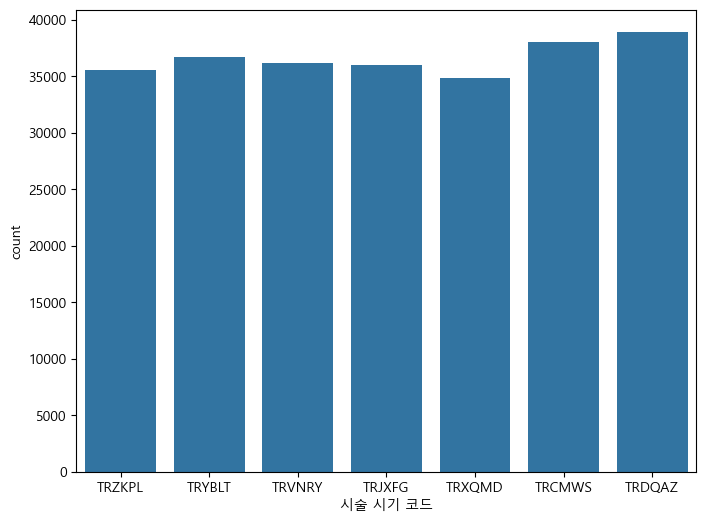

시술 시기 코드
TRDQAZ    38969
TRCMWS    38090
TRYBLT    36713
TRVNRY    36173
TRJXFG    36031
TRZKPL    35544
TRXQMD    34831
Name: count, dtype: int64


In [13]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='시술 시기 코드')
plt.show()

print(data.value_counts('시술 시기 코드'))

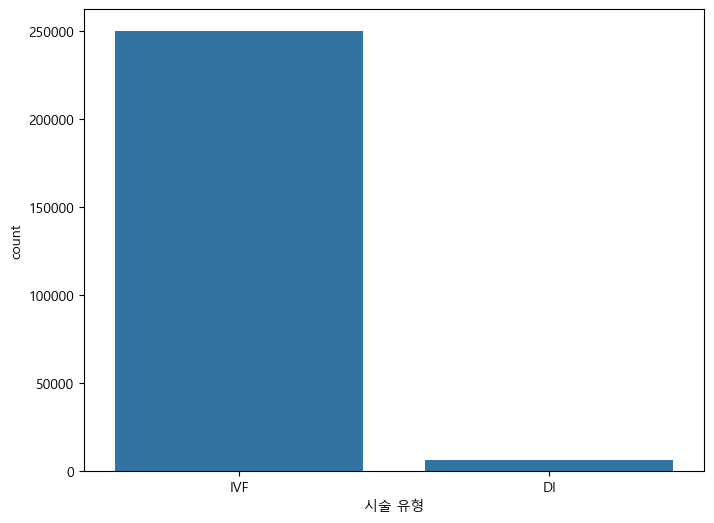

시술 유형
IVF    250060
DI       6291
Name: count, dtype: int64
시술 유형 결측치 개수: 0
시술 유형 결측치 비율: 0.00%


In [14]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='시술 유형')
plt.show()

print(data.value_counts('시술 유형'))

# 시술 유형의 결측치 개수
missing_count = data['시술 유형'].isnull().sum()

# 시술 유형의 결측치 비율
missing_percentage = (missing_count / len(data)) * 100

print(f"시술 유형 결측치 개수: {missing_count}")
print(f"시술 유형 결측치 비율: {missing_percentage:.2f}%")

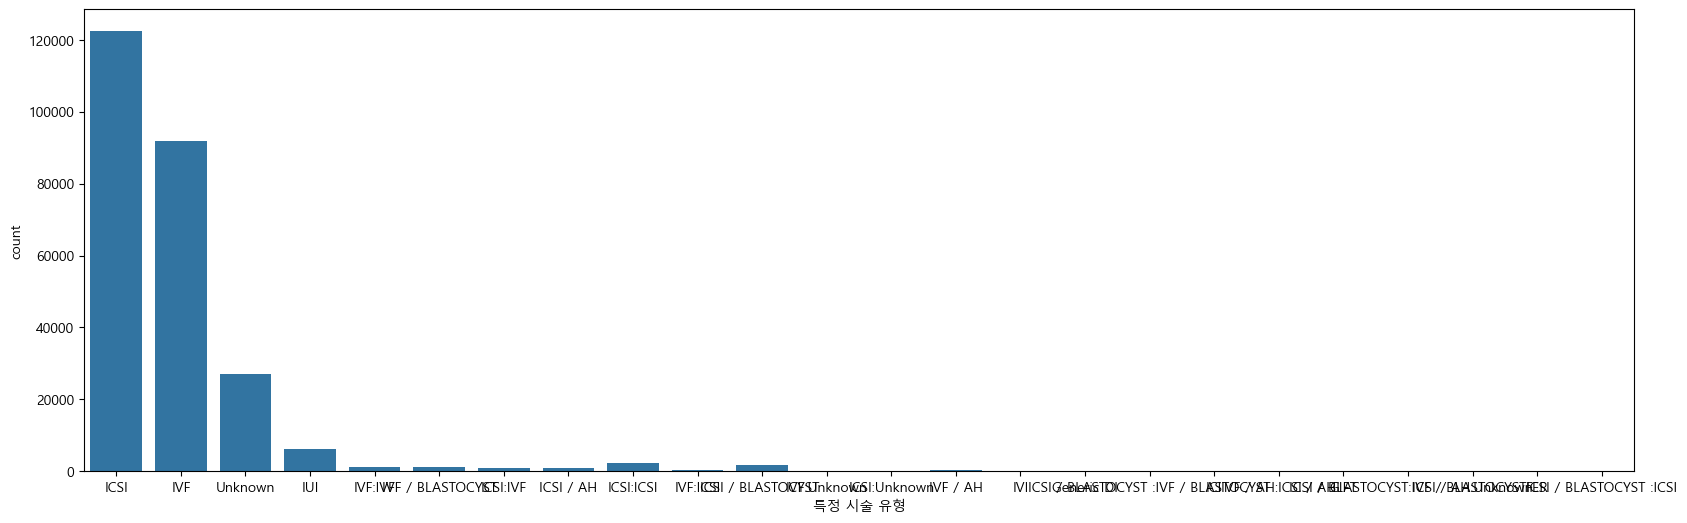

특정 시술 유형
ICSI                                   122368
IVF                                     91755
Unknown                                 26939
IUI                                      6100
ICSI:ICSI                                2314
ICSI / BLASTOCYST                        1609
IVF / BLASTOCYST                         1248
IVF:IVF                                  1146
ICSI:IVF                                  873
ICSI / AH                                 769
IVF:ICSI                                  392
IVF / AH                                  319
ICSI:Unknown                              207
IVF:Unknown                               100
ICI                                        96
Generic DI                                 71
IVI                                        23
ICSI / BLASTOCYST:IVF / BLASTOCYST          6
ICSI / BLASTOCYST :IVF / BLASTOCYST         4
FER                                         3
GIFT                                        2
ICSI / AH:Unknown        

In [15]:
plt.figure(figsize=(20,6))
sns.countplot(data=data, x='특정 시술 유형')
plt.show()

print(data.value_counts('특정 시술 유형'))

# 시술 유형의 결측치 개수
missing_count = data['특정 시술 유형'].isnull().sum()

# 시술 유형의 결측치 비율
missing_percentage = (missing_count / len(data)) * 100

print(f"특정 시술 유형 결측치 개수: {missing_count}")

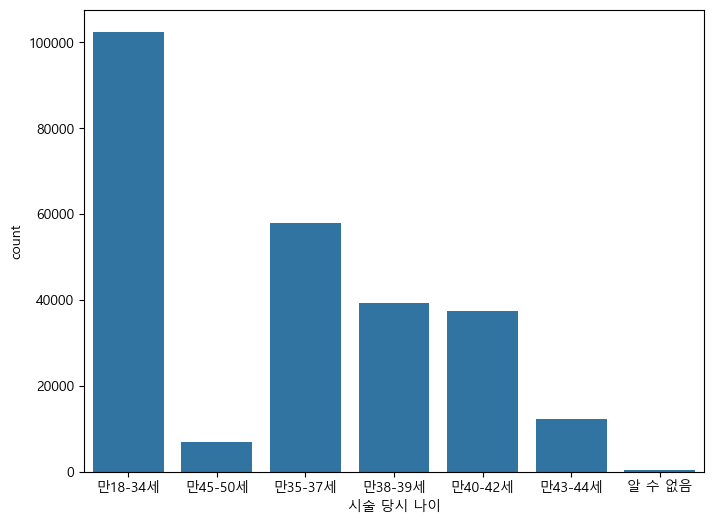

시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64
시술 당시 나이 결측치: 0


In [16]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='시술 당시 나이')
plt.show()

print(data.value_counts('시술 당시 나이'))

missing = data['시술 당시 나이'].isnull().sum()
print(f"시술 당시 나이 결측치: {missing}")

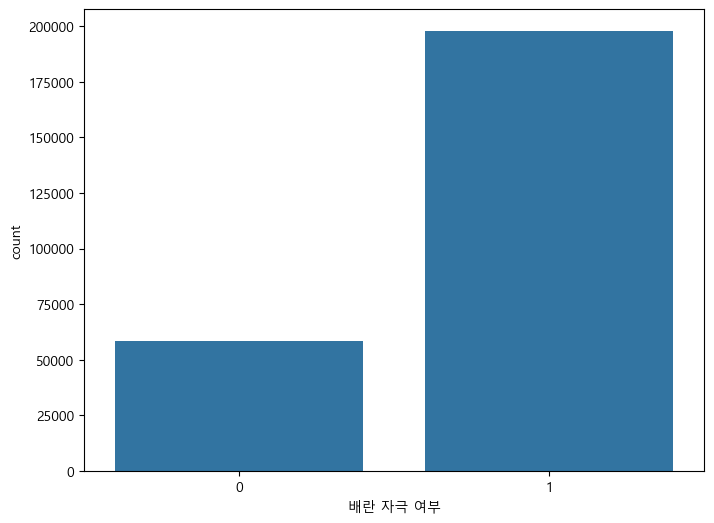

배란 자극 여부
1    197720
0     58631
Name: count, dtype: int64
배란 자극 여부 결측치 0


In [17]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='배란 자극 여부')
plt.show()

print(data.value_counts('배란 자극 여부'))

missing = data['배란 자극 여부'].isnull().sum()
print(f"배란 자극 여부 결측치 {missing}")

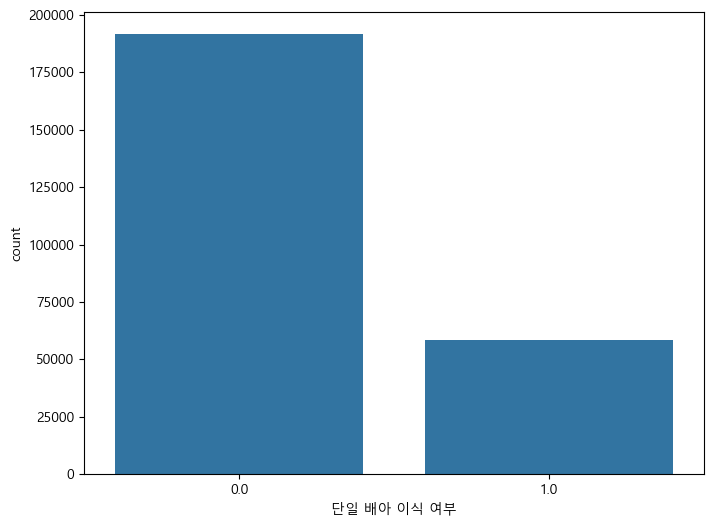

단일 배아 이식 여부
0.0    191677
1.0     58383
Name: count, dtype: int64
단일 배아 이식 여부 결측치 6291
단일 배아 이식 여부 결측치 퍼센트트: 2.45%


In [18]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='단일 배아 이식 여부')
plt.show()

print(data.value_counts('단일 배아 이식 여부'))

missing = data['단일 배아 이식 여부'].isnull().sum()

print(f"단일 배아 이식 여부 결측치 {missing}")

missing_percentage = (missing / len(data)) * 100

print(f"단일 배아 이식 여부 결측치 퍼센트트: {missing_percentage:.2f}%")

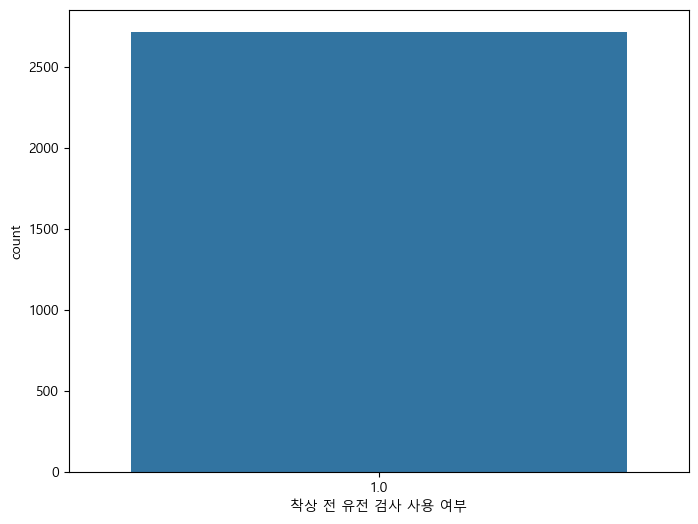

착상 전 유전 검사 사용 여부
1.0    2718
Name: count, dtype: int64
착상 전 유전검사 여부 결측치: 253633


In [19]:
plt.figure(figsize=(8,6))
sns.countplot(data=data,x='착상 전 유전 검사 사용 여부')
plt.show()

print(data['착상 전 유전 검사 사용 여부'].value_counts())

missing = data['착상 전 유전 검사 사용 여부'].isnull().sum()

print(f'착상 전 유전검사 여부 결측치: {missing}')



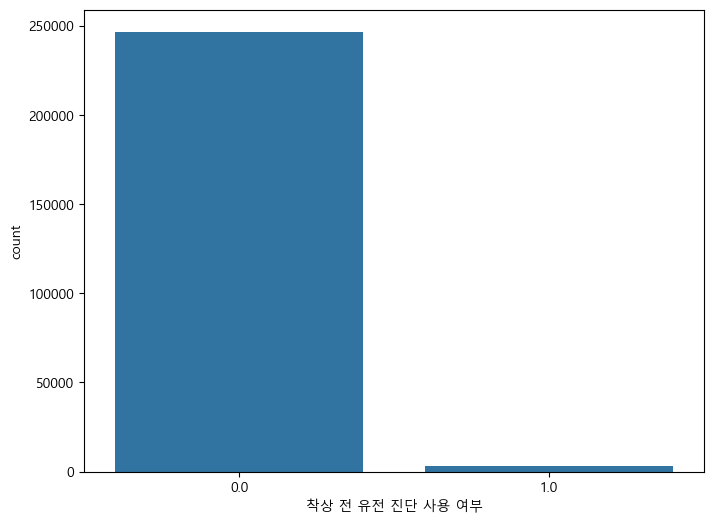

착상 전 유전 진단 사용 여부
0.0    246864
1.0      3196
Name: count, dtype: int64
착상 전 유전 진단 사용 여부 결측치 개수: 6291


In [20]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='착상 전 유전 진단 사용 여부')
plt.show()

print(data['착상 전 유전 진단 사용 여부'].value_counts())

missing = data['착상 전 유전 진단 사용 여부'].isnull().sum()
print(f"착상 전 유전 진단 사용 여부 결측치 개수: {missing}")

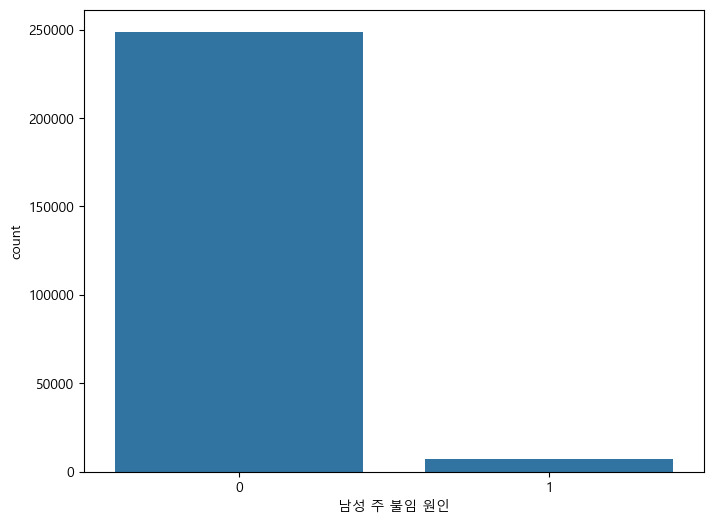

남성 주 불임 원인
0    249041
1      7310
Name: count, dtype: int64
남성 주 불임 원인 결측치 개수: 0


In [21]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='남성 주 불임 원인')
plt.show()

print(data['남성 주 불임 원인'].value_counts())

missing = data['남성 주 불임 원인'].isnull().sum()
print(f"남성 주 불임 원인 결측치 개수: {missing}")

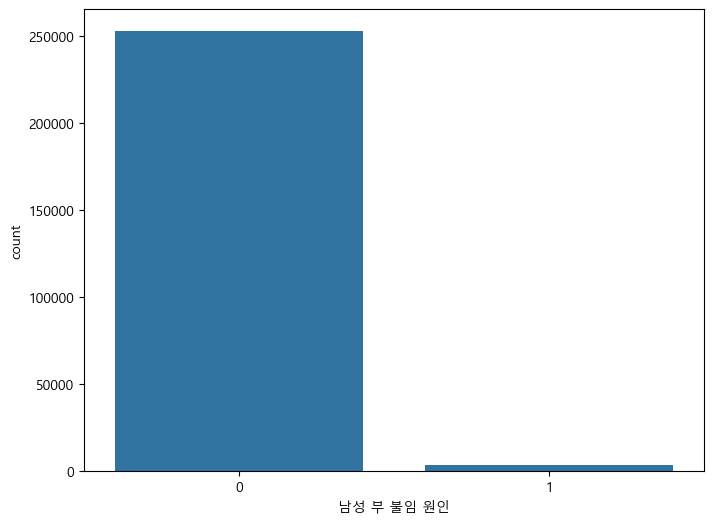

남성 부 불임 원인
0    252989
1      3362
Name: count, dtype: int64
남성 부 불임 원인 결측치 개수: 0


In [22]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='남성 부 불임 원인')
plt.show()

print(data['남성 부 불임 원인'].value_counts())

missing = data['남성 부 불임 원인'].isnull().sum()
print(f"남성 부 불임 원인 결측치 개수: {missing}")

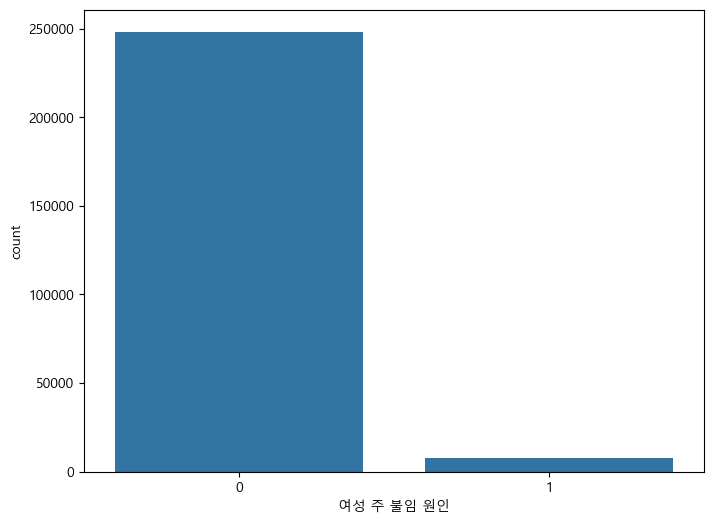

여성 주 불임 원인
0    248475
1      7876
Name: count, dtype: int64
여성 주 불임 원인 결측치 개수: 0


In [23]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='여성 주 불임 원인')
plt.show()

print(data['여성 주 불임 원인'].value_counts())

missing = data['여성 주 불임 원인'].isnull().sum()
print(f"여성 주 불임 원인 결측치 개수: {missing}")

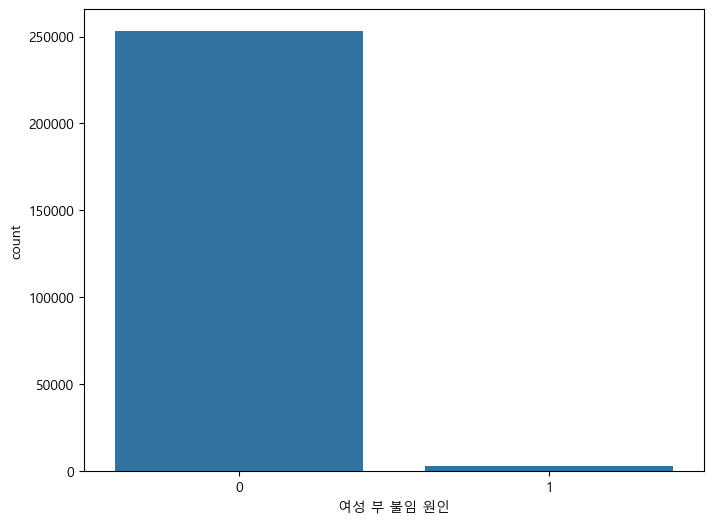

여성 부 불임 원인
0    253164
1      3187
Name: count, dtype: int64
여성 부 불임 원인 결측치: 0


In [24]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='여성 부 불임 원인')
plt.show()

print(data['여성 부 불임 원인'].value_counts())

missing = data['여성 부 불임 원인'].isnull().sum()
print(f"여성 부 불임 원인 결측치: {missing}")

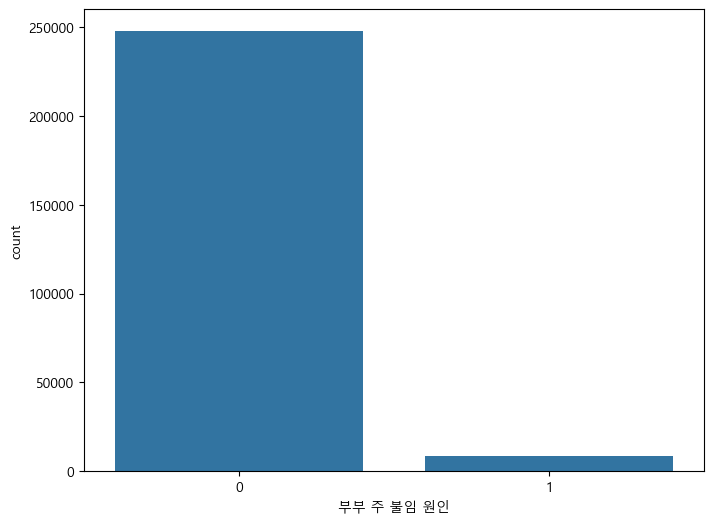

부부 주 불임 원인
0    247874
1      8477
Name: count, dtype: int64
부부 주 불임 원인 결측치 개수: 0


In [25]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='부부 주 불임 원인')
plt.show()

print(data['부부 주 불임 원인'].value_counts())

missing = data['부부 주 불임 원인'].isnull().sum()
print(f"부부 주 불임 원인 결측치 개수: {missing}")

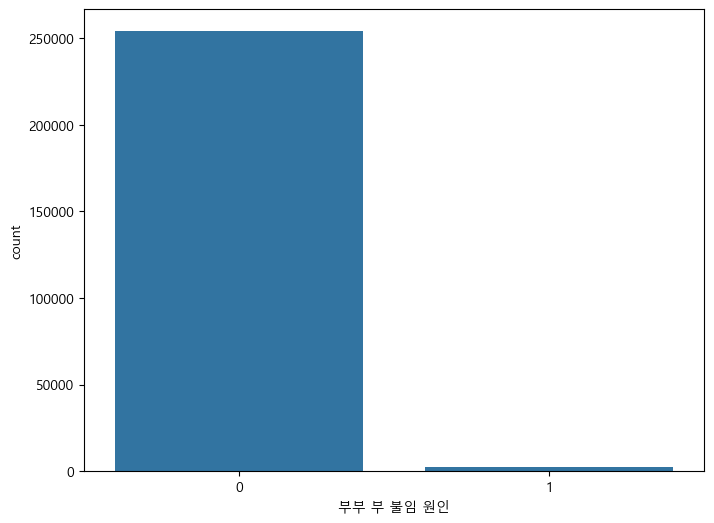

부부 부 불임 원인
0    254104
1      2247
Name: count, dtype: int64
부부 부 불임 원인 결측치 개수: 0


In [26]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='부부 부 불임 원인')
plt.show()

print(data['부부 부 불임 원인'].value_counts())

missing = data['부부 부 불임 원인'].isnull().sum()
print(f"부부 부 불임 원인 결측치 개수: {missing}")

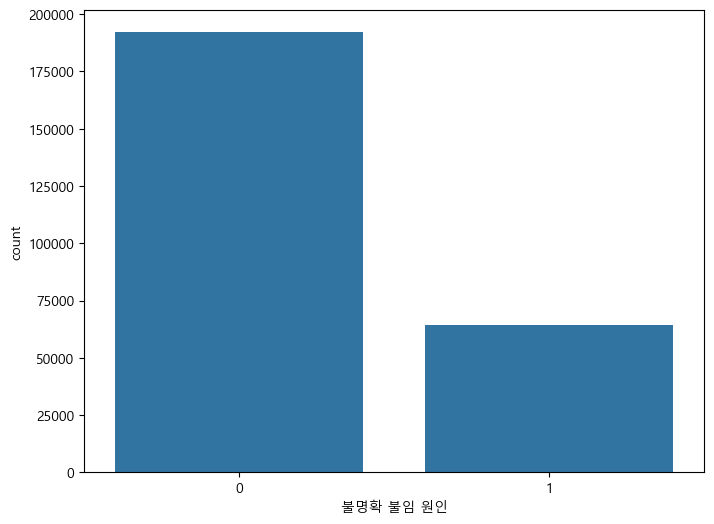

불명확 불임 원인
0    192076
1     64275
Name: count, dtype: int64
불명확 불임 원인 결측치 개수: 0


In [27]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='불명확 불임 원인')
plt.show()

print(data['불명확 불임 원인'].value_counts())

missing = data['불명확 불임 원인'].isnull().sum()
print(f"불명확 불임 원인 결측치 개수: {missing}")

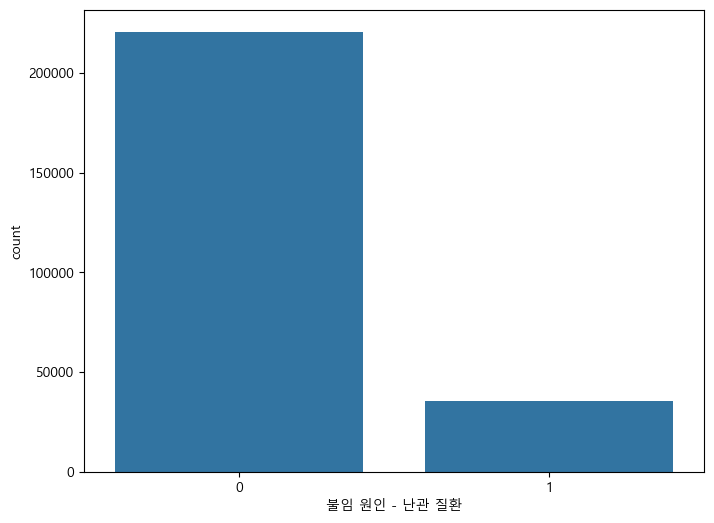

불임 원인 - 난관 질환
0    220794
1     35557
Name: count, dtype: int64
불임 원인 - 난관 질환 결측치 개수: 0


In [28]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='불임 원인 - 난관 질환')
plt.show()

print(data['불임 원인 - 난관 질환'].value_counts())

missing = data['불임 원인 - 난관 질환'].isnull().sum()
print(f"불임 원인 - 난관 질환 결측치 개수: {missing}")

### 불임 원인은 합칠 수 있음

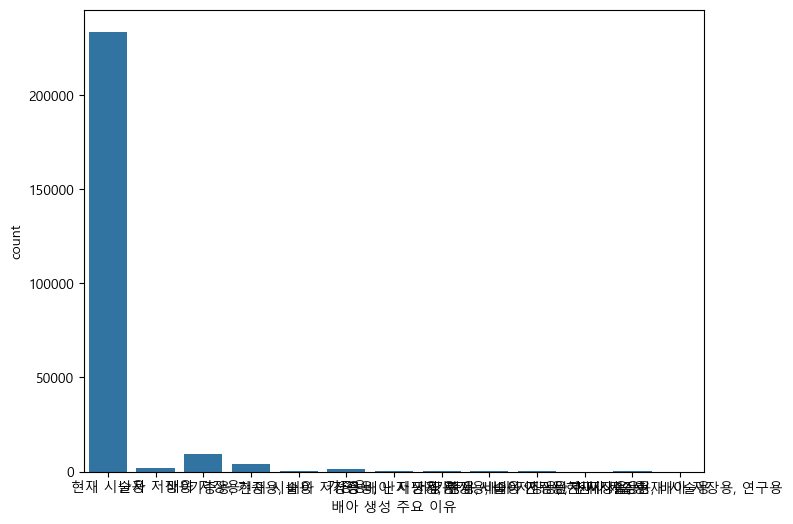

배아 생성 주요 이유
현재 시술용                 233732
배아 저장용                   9192
기증용, 현재 시술용              3784
난자 저장용                   1959
기증용                      1108
기증용, 배아 저장용               125
배아 저장용, 현재 시술용             83
기증용, 난자 저장용                44
기증용, 배아 저장용, 현재 시술용        20
난자 저장용, 배아 저장용              6
난자 저장용, 현재 시술용              5
연구용, 현재 시술용                 1
난자 저장용, 배아 저장용, 연구용         1
Name: count, dtype: int64
배아 생성 주요 이유 결측치 개수: 6291


In [29]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='배아 생성 주요 이유')
plt.show()

print(data['배아 생성 주요 이유'].value_counts())

missing = data['배아 생성 주요 이유'].isnull().sum()
print(f"배아 생성 주요 이유 결측치 개수: {missing}")

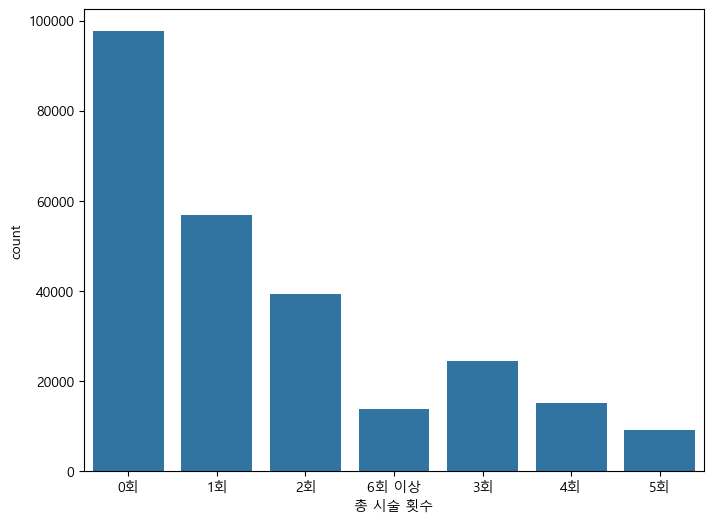

총 시술 횟수
0회       97599
1회       56819
2회       39338
3회       24531
4회       15141
6회 이상    13817
5회        9106
Name: count, dtype: int64
총 시술 횟수 결측치 개수: 0


In [30]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='총 시술 횟수')
plt.show()

print(data['총 시술 횟수'].value_counts())

missing = data['총 시술 횟수'].isnull().sum()
print(f"총 시술 횟수 결측치 개수: {missing}")

### 시술 횟수도 합치기 가능

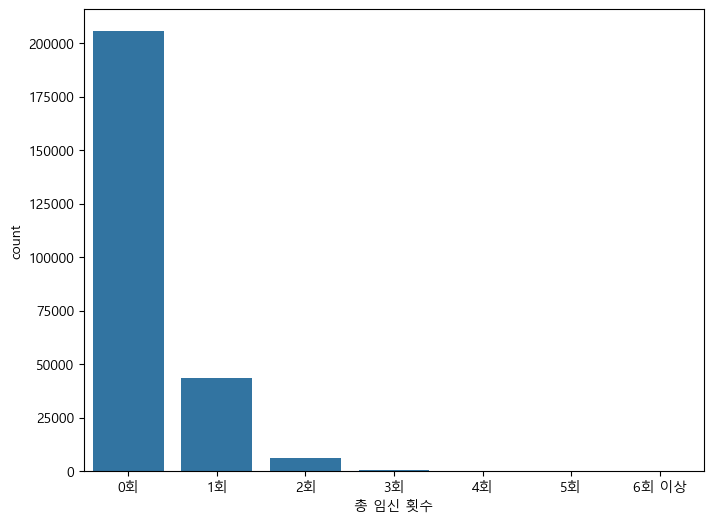

총 임신 횟수
0회       205426
1회        43829
2회         6246
3회          746
4회           93
5회            8
6회 이상         3
Name: count, dtype: int64
총 임신 횟수 결측치 개수: 0


In [31]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='총 임신 횟수')
plt.show()

print(data['총 임신 횟수'].value_counts())

missing = data['총 임신 횟수'].isnull().sum()
print(f"총 임신 횟수 결측치 개수: {missing}")

### 총 임신 횟수도 합치기 가능

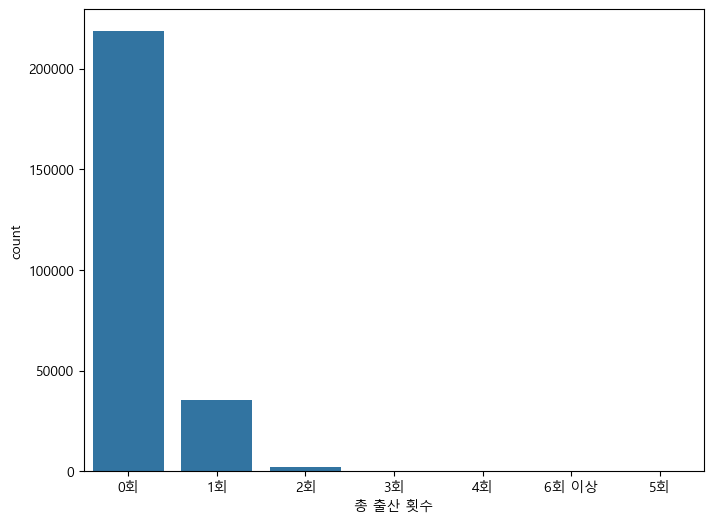

총 출산 횟수
0회       218555
1회        35369
2회         2242
3회          169
4회           13
6회 이상         2
5회            1
Name: count, dtype: int64
총 출산 횟수 결측치 개수: 0


In [32]:
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='총 출산 횟수')
plt.show()

print(data['총 출산 횟수'].value_counts())

missing = data['총 출산 횟수'].isnull().sum()
print(f"총 출산 횟수 결측치 개수: {missing}")

### 출 산 횟수도 합치기 가능한데 횟수를 합친다...는 모르겠네 